In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
import yfinance as yf
import datetime


import RECH_functions as RECH

import pickle

In [2]:
def garch_sigma_rec(parameters, y_series, t):
    """returns sigma_t - the 'current' value of sigma for forecasting"""
    omega, alpha, beta = parameters
    sigma_series = np.zeros(t)
    sigma_series[0] = omega/(1 - alpha - beta)
    for i in range(t):
        sigma_series[i + 1] = omega + alpha * y_series[i]**2 + beta * sigma_series[i]
    return sigma_series[-1]

def srn_sigma_rec(parameters, y_series, act_func, t):
    alpha, beta, gamma_0, gamma_1, v_1, v_2, w, b = parameters
    sigma_t = gamma_0/(1 - alpha - beta)
    w_t = 0
    h_t = 0
    for i in range(t):
        if i == 0:
            sigma_t = w_t + alpha * y_series[i]**2 + beta * sigma_t
        else:
            h_t = act_func( v_1 * np.sign(y_series[i]) * y_series[i]**2 + v_2 * sigma_t + w * h_t + b)
            w_t = gamma_0 + gamma_1 * h_t
            sigma_t = w_t + alpha * y_series[i]**2 + beta * sigma_t
    return sigma_t, w_t, h_t




In [3]:
act_func = RECH.relu

In [5]:
my_list = ["MMM",
"AXP",
"AMGN",
"AAPL",
"BA",
"CAT",
"CVX",
"CSCO",
"KO",
"DOW",
"GS",
"HD",
"HON",
"INTC",
"IBM",
"JNJ",
"JPM",
"MCD",
"MRK",
"MSFT",
"NKE",
"PG",
"CRM",
"TRV",
"UNH",
"VZ",
"V",
"WBA",
"WMT",
"DIS",
"^GSPC"]
my_list.remove("DOW") # dow joined in 2019
my_list.sort()

In [10]:
#forecasts_symbol = pd.DataFrame(index=os_data.index) # empty dataframe to be filles with forecasts of different horizons



my_bounds = ((0.0001,5), (0.0001,1), (0.0001, 1))
def con(t):
    return (-1)*(t[1] + t[2]) + 0.999
cons = {'type':'ineq', 'fun': con}
par_names = ["omega", "alpha", "beta"]

df_pars = pd.DataFrame(columns = par_names, index = my_list)

forecast_all = pd.DataFrame()

mc_M = 5000

act_func = RECH.relu

for symbol in my_list:
    pd_this_share = pd.read_csv("data_ret.csv")
    is_list = [(pd_this_share.index[x] < datetime.date(2017, 1, 1)) for x in range(len(pd_this_share)) ]
    is_data = pd_this_share[is_list]
    is_data.drop(index=is_data.index[0], axis=0, inplace=True) # dropping the first value with NA in returns
    is_returns = is_data['log_ret * 100']
    #is_returns = is_data['log_ret']
    print("####################")
    print(is_returns.head(4))
    print("####################")
    # out of sample data is all the data from 01.01.2015
    os_list = [(pd_this_share.index[x] >= datetime.date(2017, 1, 1)) for x in range(len(pd_this_share)) ]
    os_data = pd_this_share[os_list]
    os_returns = os_data['log_ret * 100']
    #os_returns = os_data['log_ret']
    vP0 = (0.1, 0.1, 0.8)
    my_bounds = ((0.0001,1), (0.0001,1), (0.0001, 1))

    update_window = 20 # length of the updating window 20 -> monthly, 5 -> weekly
    sample_returns = is_returns # the sample returns serires keeps getting longer: after each iteration new informatuion is added
    os_decreasing = os_returns # out of sample returns, shrinking as sample increases
    forecasts_symbol = pd.DataFrame(index=os_data.index)
    horizons = (1, 5, 20)
    for p in range(len(horizons)):
        forecasts_symbol[symbol + f"_{horizons[p]}_h"] = np.zeros(len(os_returns))
    #print(symbol + f"_{horizons[p]}_h")
    print(forecasts_symbol.columns)
    for i in range(int(len(os_returns)/update_window)):
        if i == 0:
            # different starting values for optimisation as well as for forecasting in the first iteration
            res_garch = opt.minimize(RECH.garch_loglike, vP0, args = (act_func, sample_returns),
                          bounds = my_bounds,
                           #method = "Nelder-Mead",
                            method = "SLSQP",      
                          options = {"disp": False, "maxiter": 100000},
                            constraints = cons)
            # sample returns contain all information up to t = t
            # mc forecast function uses the lastest return as information
            
            for k in range(update_window):
                """for every time (t+1), (t+2), ... there are 3 forecasts made with respective information
                (t+1)-h1, (t+1)-h2, (t+1)-h3, (t+2)-h1, ... """
                for horizon in horizons:
                    fore = RECH.mc_garch2(res_garch.x, sample_returns[:-horizon], mc_M, horizon)
                    forecasts_symbol[symbol + f"_{horizon}_h"].iloc[i*update_window + k] = fore
                ### now for every k the sample grows by 1
                sample_returns = sample_returns.append(os_decreasing.head(1))
                os_decreasing = os_decreasing.tail(-1)
                
        else:
            sample_returns = sample_returns.tail(-update_window)
            new_bounds = my_bounds
            res_garch = opt.minimize(RECH.garch_loglike, res_garch.x, args = (act_func, sample_returns),
                          bounds = new_bounds,
                           #method = "Nelder-Mead",
                            method = "SLSQP",
                          options = {"disp": False, "maxiter": 10000},
                            constraints = cons)
            for k in range(update_window):
                """for every time (t+1), (t+2), ... there are 3 forecasts made with respective information
                (t+1)-h1, (t+1)-h2, (t+1)-h3, (t+2)-h1, ... """
                for horizon in horizons:
                    fore = RECH.mc_garch2(res_garch.x, sample_returns[:-horizon], mc_M, horizon)
                    forecasts_symbol[symbol + f"_{horizon}_h"].iloc[i*update_window + k] = fore
                ### now for every k the sample grows by 1
                sample_returns = sample_returns.append(os_decreasing.head(1))
                os_decreasing = os_decreasing.tail(-1)
                #print(f"in sample: {len(sample_returns)}, out of sample: {len(os_decreasing)}")
    forecast_all = pd.concat([forecast_all, forecasts_symbol], axis=1)
    df_pars.iloc[my_list.index(symbol)] = res_garch.x        

[*********************100%***********************]  1 of 1 completed
####################
Date
2005-01-04 00:00:00-05:00    0.373276
2005-01-05 00:00:00-05:00   -0.223790
2005-01-06 00:00:00-05:00   -0.112144
2005-01-07 00:00:00-05:00   -0.299471
Name: log_ret * 100, dtype: float64
####################
Index(['MSFT_1_h', 'MSFT_5_h', 'MSFT_20_h'], dtype='object')
[0.04270064 0.03322824 0.94929237]
[0.04268452 0.03281264 0.94969993]
[0.04002709 0.03165997 0.95203776]
[0.03916414 0.0323744  0.95185415]
[0.03807655 0.03296405 0.9514991 ]
[0.0364391  0.03160127 0.95343704]
[0.03581969 0.03125086 0.95426105]
[0.03622341 0.03156046 0.95375617]
[0.0351208  0.03088161 0.95454203]
[0.03444432 0.03077708 0.95507168]
[0.03339075 0.03072435 0.95556193]
[0.0335616  0.02779362 0.95830603]
[0.02992115 0.0260785  0.96180306]
[0.0249239  0.0250276  0.96523538]
[0.02543028 0.02710902 0.96372464]
[0.02034423 0.03253083 0.9626236 ]
[0.01627538 0.03903699 0.95857531]
[0.01953046 0.03293085 0.95993406]
[0.02

In [11]:
#df_pars.to_csv("results/garch_pars_5march.csv")
#forecast_all.to_csv("results/garch_forecasts_5march.csv")

In [13]:
forecast_all

,MSFT_1_h,MSFT_5_h,MSFT_20_h
Date,,,
2017-01-03 00:00:00-05:00,1.563900,1.633319,2.074318
2017-01-04 00:00:00-05:00,1.527978,0.890536,3.028166
2017-01-05 00:00:00-05:00,1.542302,3.199438,8.286733
2017-01-06 00:00:00-05:00,1.523338,2.517343,1.413972
2017-01-09 00:00:00-05:00,1.495475,2.016823,2.063498
...,...,...,...
2020-09-24 00:00:00-04:00,3.912367,2.225919,4.004720
2020-09-25 00:00:00-04:00,4.113142,2.259455,3.987534
2020-09-28 00:00:00-04:00,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='Date'>

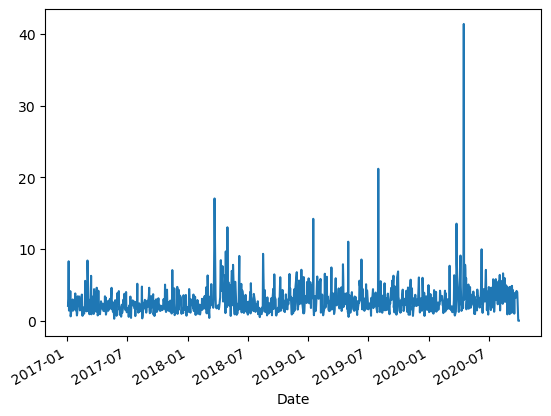

In [22]:
forecast_all["MSFT_20_h"].plot()
#plt.savefig("GARCH0702.png")

In [19]:
#forecast_all["MSFT_2_h"].plot()

In [20]:
#forecast_all["MSFT_3_h"].plot()